# Disciple - 取引シミュレーション（Jupyter用）

In [1]:
import datetime
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.conv import conv_transaction_df2html
from funcs.setting import load_setting
from funcs.tide import get_date_dir_from_file
from funcs.tse import get_ticker_name_list
from modules.disciple import Disciple
from structs.res import AppRes

In [2]:
res = AppRes()

excel = "ticks_20260116.xlsx"
code = "7011"
# code = "7203"
# code = "8306"
dict_setting = load_setting(res, code)
THRESHOLD_SLOPE = dict_setting["THRESHOLD_SLOPE"]
TURBULENCE = dict_setting["TURBULENCE"]
date_str = get_date_dir_from_file(excel)
print(date_str)

app = Disciple(excel, code, dict_setting)
app.run()

2026/01/16
パラメータ
PERIOD_WARMUP : 180
PERIOD_MA_1 : 60
PERIOD_MA_2 : 450
PERIOD_SLOPE : 5
THRESHOLD_SLOPE : 0.05
PERIOD_RR : 30
TURBULENCE : 35.0
LOSSCUT_1 : -25
THRESHOLD_PM_MIN : 25.0
THRESHOLD_DDR_MIN : 0.6
N_MINUS_MAX : 240


In [3]:
# 取引明細
df_transaction = app.getTransaction()
df_transaction["累積損益"] = df_transaction["損益"].fillna(0).cumsum()
print("取引明細")
print(df_transaction)
print(df_transaction["注文日時"].dtype)
print(df_transaction["累積損益"].dtype)

list_html = conv_transaction_df2html(df_transaction)

output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_transaction.html")
print(output)
with open(output, mode="w") as f:
    f.write("\n".join(list_html))

list_trans = df_transaction["注文日時"]
n_trade = len(df_transaction)
total = df_transaction["損益"].sum()
print(f"取引回数: {n_trade} 回 / 総収益: {total} 円/株")

取引明細
    注文番号                          注文日時 銘柄コード  売買  約定単価  約定数量      損益 備考  \
0      1 2026-01-16 09:03:11.626276016  7011  売建  4750   100     NaN      
1      2 2026-01-16 09:11:13.235340118  7011  買埋  4722   100  2800.0      
2      3 2026-01-16 09:11:14.224062920  7011  買建  4722   100     NaN      
3      4 2026-01-16 09:18:29.388034105  7011  売埋  4738   100  1600.0      
4      5 2026-01-16 09:18:30.379693985  7011  売建  4738   100     NaN      
..   ...                           ...   ...  ..   ...   ...     ... ..   
67    68 2026-01-16 15:09:07.062762976  7011  買埋  4666   100  -200.0      
68    69 2026-01-16 15:09:08.068876982  7011  買建  4666   100     NaN      
69    70 2026-01-16 15:13:54.813420057  7011  売埋  4663   100  -300.0      
70    71 2026-01-16 15:16:50.488373995  7011  買建  4667   100     NaN      
71    72 2026-01-16 15:19:02.885088921  7011  売埋  4666   100  -100.0      

       累積損益  
0       0.0  
1    2800.0  
2    2800.0  
3    4400.0  
4    4400.0  
..      ..

In [4]:
# Matplotlib の共通設定
FONT_PATH = "fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

In [5]:
"""
累積損益のトレンドを作成するための準備
"""

# 元データ
ts = df_transaction["注文日時"]
pl = df_transaction["累積損益"]

# 日付（年月日）だけ取り出す
date = ts.iloc[0].normalize()

# 追加する先頭と末尾の行
start_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=9)],
        "累積損益": [0.0],
    }
)

end_row = pd.DataFrame(
    {
        "注文日時": [date + pd.Timedelta(hours=15, minutes=30)],
        "累積損益": [pl.iloc[-1]],
    }
)

# トレンド用 DataFrame を作成
trend_df = pd.concat(
    [start_row, df_transaction[["注文日時", "累積損益"]], end_row], ignore_index=True
)

# 注文日時を index にした Series を作成
trend_series = trend_df.set_index("注文日時")["累積損益"]
trend_series

注文日時
2026-01-16 09:00:00.000000000        0.0
2026-01-16 09:03:11.626276016        0.0
2026-01-16 09:11:13.235340118     2800.0
2026-01-16 09:11:14.224062920     2800.0
2026-01-16 09:18:29.388034105     4400.0
                                  ...   
2026-01-16 15:09:08.068876982    10300.0
2026-01-16 15:13:54.813420057    10000.0
2026-01-16 15:16:50.488373995    10000.0
2026-01-16 15:19:02.885088921     9900.0
2026-01-16 15:30:00.000000000     9900.0
Name: 累積損益, Length: 74, dtype: float64

output/2026/01/16/7011_trend_profit.png


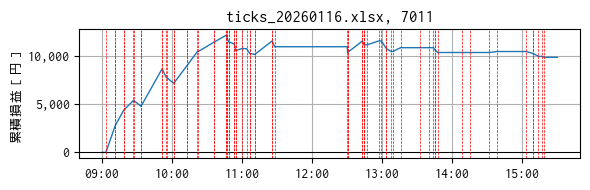

In [6]:
# 累積損益トレンド
fig, ax = plt.subplots(figsize=(6, 2))

ax.set_title(f"{excel}, {code}")
ax.plot(trend_series, linewidth=1)
ax.axhline(y=0, color="black", linewidth=0.75)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("累積損益［円］")
for t in list_trans:
    ax.axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)
ax.grid()

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_profit.png")
print(output)
plt.savefig(output)
plt.show()

In [7]:
# テクニカル指標
print("テクニカル指標")
df_tech = app.getTechnicals()
print(df_tech)

テクニカル指標
                               ts  price          ma1          ma2  disparity  \
2026-01-16 09:00:04  1.768522e+09   4756  4756.000000  4756.000000   0.000000   
2026-01-16 09:00:05  1.768522e+09   4756  4756.000000  4756.000000   0.000000   
2026-01-16 09:00:06  1.768522e+09   4770  4760.666667  4760.666667   0.000000   
2026-01-16 09:00:07  1.768522e+09   4770  4763.000000  4763.000000   0.000000   
2026-01-16 09:00:08  1.768522e+09   4758  4762.000000  4762.000000   0.000000   
...                           ...    ...          ...          ...        ...   
2026-01-16 15:24:45  1.768545e+09   4670  4667.366667  4665.931111   0.000308   
2026-01-16 15:24:46  1.768545e+09   4670  4667.433333  4665.942222   0.000320   
2026-01-16 15:24:47  1.768545e+09   4668  4667.466667  4665.948889   0.000325   
2026-01-16 15:24:48  1.768545e+09   4668  4667.500000  4665.955556   0.000331   
2026-01-16 15:24:49  1.768545e+09   4667  4667.516667  4665.960000   0.000334   

                   

In [8]:
df_tech["slope1"].describe()

count    19427.000000
mean         0.050672
std          0.065044
min          0.000000
25%          0.016667
50%          0.033333
75%          0.066667
max          2.800000
Name: slope1, dtype: float64

output/2026/01/16/7011_trend_technical.png


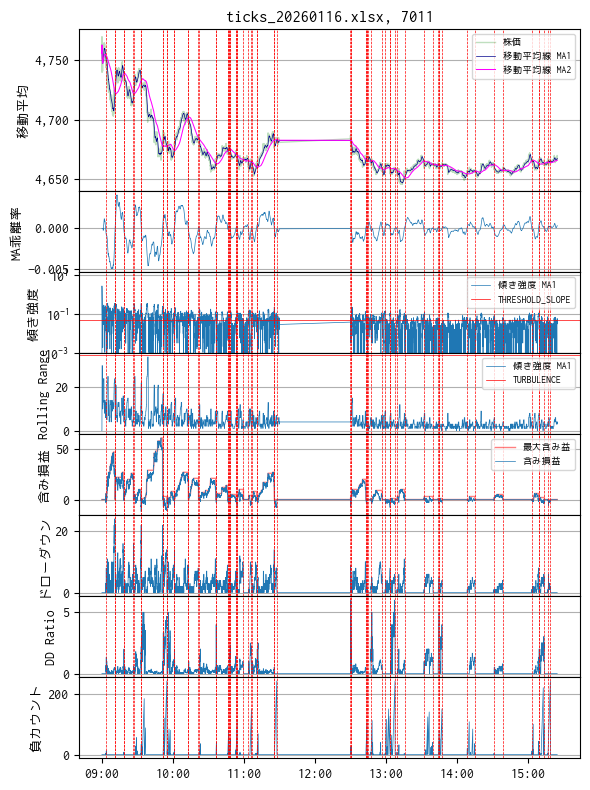

In [15]:
fig = plt.figure(figsize=(6, 8))
n = 8
ax = dict()
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")
ax[0].plot(df_tech["price"], linewidth=1, color="green", alpha=0.25, label="株価")
ax[0].plot(df_tech["ma1"], linewidth=0.5, color="darkblue", label="移動平均線 MA1")
ax[0].plot(df_tech["ma2"], linewidth=0.75, color="magenta", label="移動平均線 MA2")
ax[0].set_ylabel("移動平均")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax[0].legend(fontsize=7)

ax[1].plot(df_tech["disparity"], linewidth=0.5, label="MA乖離率")
ax[1].set_ylabel("MA乖離率")

ax[2].plot(df_tech["slope1"], linewidth=0.5, label="傾き強度 MA1")
ax[2].axhline(y=THRESHOLD_SLOPE, color="red", linewidth=0.5, label="THRESHOLD_SLOPE")
ax[2].set_yscale("log")
ax[2].set_ylabel("傾き強度")
ax[2].legend(fontsize=7)
_, y_high = ax[2].get_ylim()
ax[2].set_ylim(0.001, y_high)

ax[3].plot(df_tech["rr"], linewidth=0.5, label="傾き強度 MA1")
ax[3].axhline(y=TURBULENCE, color="red", linewidth=0.5, label="TURBULENCE")
ax[3].set_ylabel("Rolling Range")
ax[3].legend(fontsize=7)

ax[4].plot(
    df_tech["profit_max"], linewidth=1, color="red", alpha=0.5, label="最大含み益"
)
ax[4].plot(df_tech["profit"], linewidth=0.5, color="C0", label="含み損益")
ax[4].set_ylabel("含み損益")
ax[4].legend(fontsize=7)

ax[5].plot(df_tech["drawdown"], linewidth=0.5)
ax[5].set_ylabel("ドローダウン")

ax[6].plot(df_tech["dd_ratio"], linewidth=0.5)
ax[6].set_ylabel("DD Ratio")

ax[7].plot(df_tech["n_minus"], linewidth=0.5)
ax[7].set_ylabel("負カウント")

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dashed", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_technical.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/16/7011_hist_slope.png


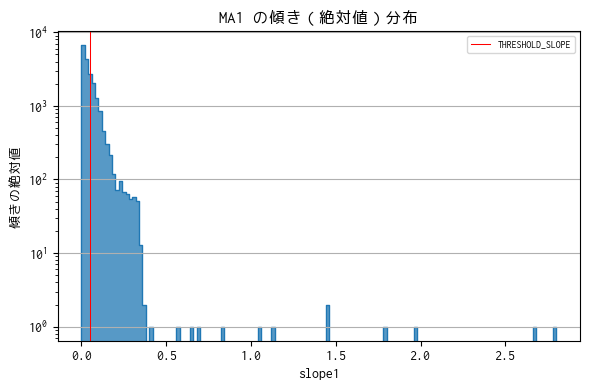

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("MA1 の傾き（絶対値）分布")
sns.histplot(data=df_tech, x="slope1", bins="sqrt", element="step")
ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
ax.set_yscale("log")
ax.set_ylabel("傾きの絶対値")
ax.grid(axis="y")
ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_slope.png")
print(output)
plt.savefig(output)
plt.show()

output/2026/01/16/7011_hist_rr.png


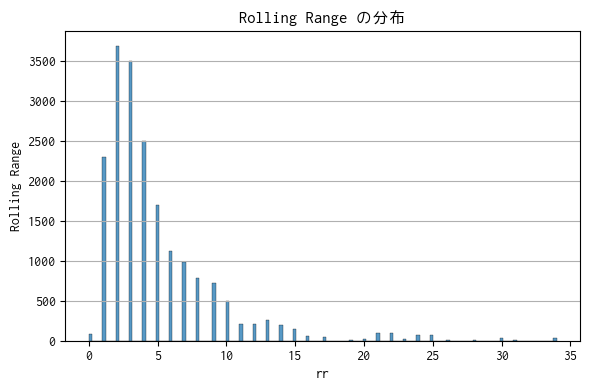

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Rolling Range の分布")
sns.histplot(data=df_tech, x="rr", bins="sqrt")
# ax.axvline(x=THRESHOLD_SLOPE, color="red", linewidth=0.75, label="THRESHOLD_SLOPE")
# ax.set_yscale("log")
ax.set_ylabel("Rolling Range")
ax.grid(axis="y")
# ax.legend(fontsize=7)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_hist_rr.png")
print(output)
plt.savefig(output)
plt.show()

In [13]:
# 観測値
print("観測値")
df_obs = app.getObservations()
print(df_obs)

観測値
                     クロスS1  クロスS2  クロ強  乱高下  ロス1  ロス2  利確1   建玉
2026-01-16 09:00:04    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:05    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:06    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:07    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 09:00:08    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
...                    ...    ...  ...  ...  ...  ...  ...  ...
2026-01-16 15:24:45    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:46    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:47    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:48    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0
2026-01-16 15:24:49    0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0

[19427 rows x 8 columns]


output/2026/01/16/7011_trend_obs.png


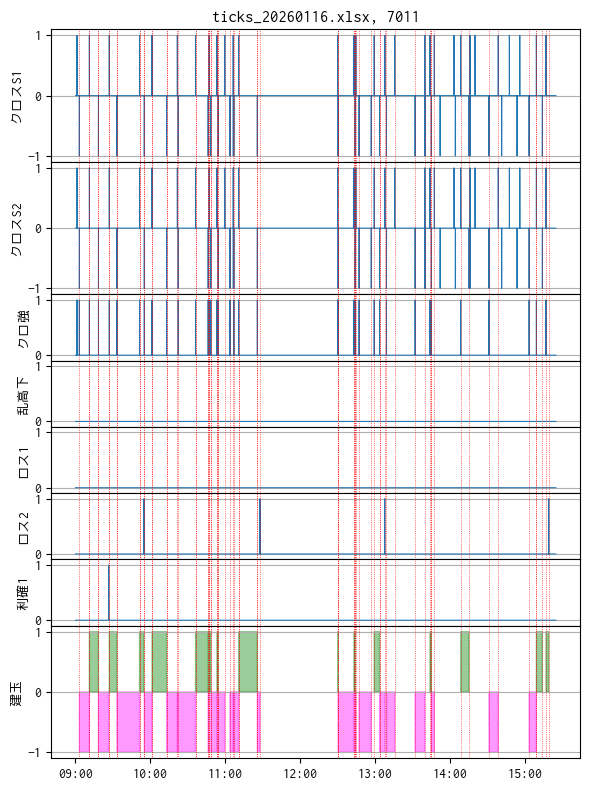

In [14]:
n = len(df_obs.columns)
fig = plt.figure(figsize=(6, n))
ax = dict()

targets = {"クロスS1", "クロスS2", "建玉"}
list_height_ratio = [2 if col in targets else 1 for col in df_obs.columns]
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=list_height_ratio)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid(axis="y")

ax[0].set_title(f"{excel}, {code}")

special_cross = {"クロスS1", "クロスS2"}

for i, colname in enumerate(df_obs.columns):
    ax_i = ax[i]

    if colname in special_cross:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-1.1, 1.1)

    elif colname == "建玉":
        x = df_obs.index
        y = df_obs[colname]
        ax_i.fill_between(
            x, 0, y, where=y > 0, color="green", alpha=0.4, interpolate=True
        )
        ax_i.fill_between(
            x, 0, y, where=y < 0, color="magenta", alpha=0.4, interpolate=True
        )
        ax_i.set_ylim(-1.1, 1.1)

    else:
        ax_i.plot(df_obs[colname], linewidth=0.75)
        ax_i.set_ylim(-0.1, 1.1)

    ax_i.set_ylabel(colname)
    ax_i.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for i in range(n):
    for t in list_trans:
        ax[i].axvline(x=t, color="red", linestyle="dotted", linewidth=0.5)

plt.tight_layout()
output_dir = os.path.join("output", date_str)
os.makedirs(output_dir, exist_ok=True)
output = os.path.join(output_dir, f"{code}_trend_obs.png")
print(output)
plt.tight_layout()
plt.savefig(output)
plt.show()